In [1]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.3.0


In [2]:
def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

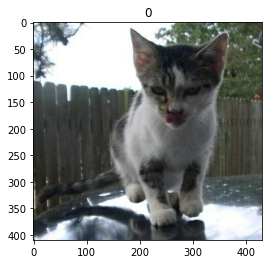

In [3]:
image, label = load(r"E:\uni\Y4S1\IE4483\datasets\train\cat\cat.11.jpg", 0)

fig, ax = plt.subplots()
ax.imshow(image /255.)
ax.set_title(label)
plt.show()

In [4]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

In [5]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 3])

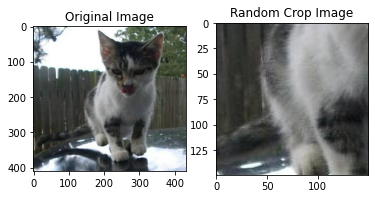

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Random Crop Image")
plt.show()

In [7]:
def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

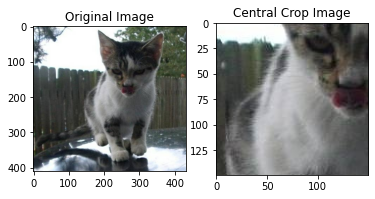

In [8]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
ax[1].set_title("Central Crop Image")
plt.show()

In [9]:
def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

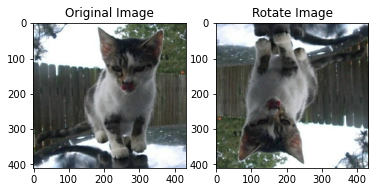

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_rotation(image) / 255.)
ax[1].set_title("Rotate Image")
plt.show()

In [11]:
def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image

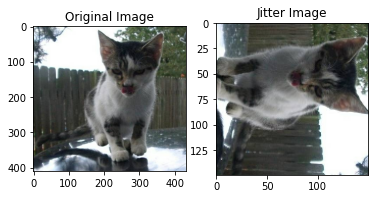

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_jitter(image) / 255.)
ax[1].set_title("Jitter Image")
plt.show()

In [13]:
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

In [14]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
    image = random_jitter(image)
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label

In [15]:
temp_ds = tf.data.Dataset.list_files(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'train', 'cat', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join(r'E:\uni\Y4S1\IE4483\datasets', 'train', 'dog', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

train_ds = temp_ds.concatenate(temp2_ds)

In [16]:
buffer_size = tf.data.experimental.cardinality(train_ds).numpy()
train_ds = train_ds.shuffle(buffer_size)\
                   .map(load_image_train, num_parallel_calls=16)\
                   .batch(20)\
                   .repeat()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [17]:
temp_ds = tf.data.Dataset.list_files(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'val', 'cat', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

temp2_ds = tf.data.Dataset.list_files(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'val', 'dog', '*.jpg'))
temp2_ds = temp2_ds.map(lambda x: (x, 1))

val_ds = temp_ds.concatenate(temp2_ds)

val_ds = val_ds.map(load_image_val, num_parallel_calls=16)\
               .batch(20)\
               .repeat()

In [18]:
temp_ds = tf.data.Dataset.list_files(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'test', '*.jpg'))
temp_ds = temp_ds.map(lambda x: (x, 0))

test_ds = temp_ds.map(load_image_val, num_parallel_calls=16)\
                .shuffle(buffer_size)\
               .batch(20)\
               .repeat()

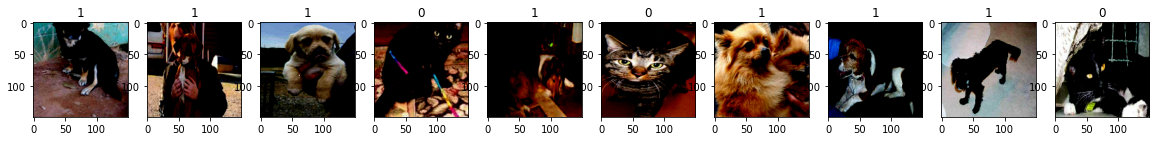

In [19]:
for images, labels in train_ds.take(1):
    fig, ax = plt.subplots(1, 10, figsize=(20, 6))
    for j in range(10):
        image = images[j].numpy()
        image = image / np.amax(image)
        image = np.clip(image, 0, 1)
        ax[j].imshow(image)
        ax[j].set_title(labels[j].numpy())
plt.show()

In [20]:
class Conv(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(Conv, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        
    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [21]:
model = tf.keras.Sequential(name='Cat_Dog_CNN')

model.add(Conv(filters=32, kernel_size=(3, 3)))
model.add(Conv(filters=64, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(Conv(filters=128, kernel_size=(3, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

In [22]:
model(images[:1])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.65235823, 0.34764177]], dtype=float32)>

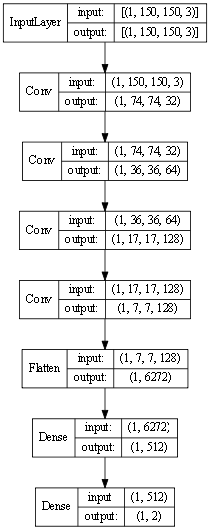

In [23]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [24]:
checkpoint_path = "./train/cat_dog_cnn/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "Cat_Dog_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  (1, 74, 74, 32)           1024      
_________________________________________________________________
conv_1 (Conv)                (1, 36, 36, 64)           18752     
_________________________________________________________________
conv_2 (Conv)                (1, 17, 17, 128)          74368     
_________________________________________________________________
conv_3 (Conv)                (1, 7, 7, 128)            148096    
_________________________________________________________________
flatten (Flatten)            (1, 6272)                 0         
_________________________________________________________________
dense (Dense)                (1, 512)                  3211776   
_________________________________________________________________
dense_1 (Dense)              (1, 2)                    

In [26]:
train_len = len(glob(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'train', 'cat', '*.jpg'))) * 2
val_len = len(glob(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'val', 'cat', '*.jpg'))) * 2
test_len = len(glob(os.path.join(r"E:\uni\Y4S1\IE4483\datasets", 'test',  '*.jpg'))) 

In [27]:
epochs=40

history = model.fit(train_ds, steps_per_epoch=train_len / 20,
          validation_data=val_ds,
          validation_steps=val_len/20,
          epochs = epochs,
          callbacks=[cp_callback]
          )

Epoch 1/40
284/284 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.5900
Epoch 00001: val_loss improved from inf to 0.79544, saving model to ./train/cat_dog_cnn\cp-0001.ckpt
284/284 [==============================] - 140s 491ms/step - loss: 0.7325 - accuracy: 0.5900 - val_loss: 0.7954 - val_accuracy: 0.5075
Epoch 2/40
284/284 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6678
Epoch 00002: val_loss improved from 0.79544 to 0.62070, saving model to ./train/cat_dog_cnn\cp-0002.ckpt
284/284 [==============================] - 155s 548ms/step - loss: 0.6149 - accuracy: 0.6678 - val_loss: 0.6207 - val_accuracy: 0.6580
Epoch 3/40
284/284 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6886
Epoch 00003: val_loss improved from 0.62070 to 0.55852, saving model to ./train/cat_dog_cnn\cp-0003.ckpt
284/284 [==============================] - 149s 526ms/step - loss: 0.5859 - accuracy: 0.6886 - val_loss: 0.5585 - val_accuracy: 0.7

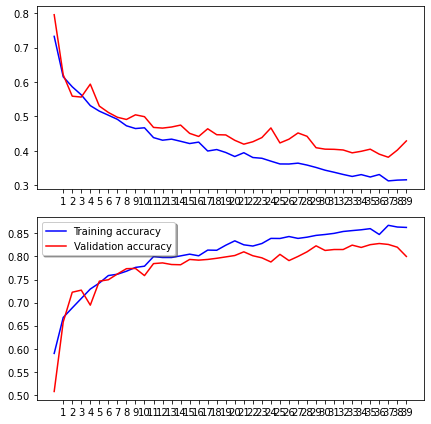

In [28]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()
    
plot_loss(history)

In [29]:
model.evaluate(test_ds, steps=test_len / 20)

25/25 [==============================] - 2s 60ms/step - loss: 1.0439 - accuracy: 0.6100


[1.0438646078109741, 0.6100000143051147]

In [30]:
model_inf = tf.keras.Sequential(name='Cat_Dog_CNN_load')

model_inf.add(Conv(filters=32, kernel_size=(3, 3)))
model_inf.add(Conv(filters=64, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))
model_inf.add(Conv(filters=128, kernel_size=(3, 3)))

model_inf.add(tf.keras.layers.Flatten())  
model_inf.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)) 
model_inf.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))  

model_inf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

for images, labels in train_ds.take(1):
    outputs = model_inf(images, training=False)
    
# Load model
model_inf.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
model_inf.evaluate(test_ds, steps=test_len / 20)

25/25 [==============================] - 2s 61ms/step - loss: 1.5258 - accuracy: 0.5040


[1.5258063077926636, 0.5040000081062317]

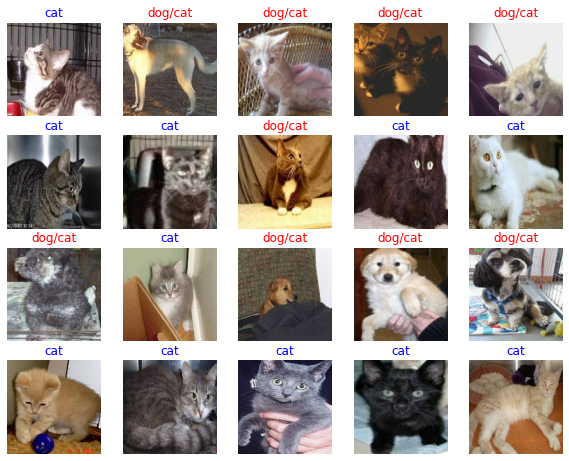

In [32]:
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model_inf(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

In [33]:
# Define the data directory and image size
test_dir = "./datasets/test"
size = (150, 150)

batch_size = 20

# List filenames in the test directory
filenames = os.listdir(test_dir)
# print("Filenames:", filenames)


# Create a DataFrame for test data
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Adjust preprocessing as needed
test_idg = test_datagen.flow_from_dataframe(
    test_data,
    test_dir,
    x_col="filename",
    y_col='label',
    batch_size=batch_size,
    target_size=size,
    shuffle=False,
)

# Make predictions
test_predict = model.predict(test_idg, verbose=0)
test_predict_argmax = np.argmax(test_predict, axis=1)

# Map predictions to labels
label_mapping = {0: '0', 1: '1'}
# test_data['label'] = test_predict_argmax.map(label_mapping)
test_data['label'] = pd.Series(test_predict_argmax).map(label_mapping)


# Output to CSV
test_data.to_csv('test_predictions.csv', index=False)

Found 500 validated image filenames belonging to 1 classes.


In [34]:
conv_vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                        include_top=False,
                                        input_shape=(150, 150, 3))

In [35]:
model_vgg = tf.keras.Sequential(name='Cat_Dog_CNN_VGG16')
model_vgg.add(conv_vgg16)
model_vgg.add(tf.keras.layers.Flatten())
model_vgg.add(tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu))
model_vgg.add(tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax))

In [36]:
for variable in model_vgg.trainable_variables:
    print(variable.name)

block1_conv1/kernel:0
block1_conv1/bias:0
block1_conv2/kernel:0
block1_conv2/bias:0
block2_conv1/kernel:0
block2_conv1/bias:0
block2_conv2/kernel:0
block2_conv2/bias:0
block3_conv1/kernel:0
block3_conv1/bias:0
block3_conv2/kernel:0
block3_conv2/bias:0
block3_conv3/kernel:0
block3_conv3/bias:0
block4_conv1/kernel:0
block4_conv1/bias:0
block4_conv2/kernel:0
block4_conv2/bias:0
block4_conv3/kernel:0
block4_conv3/bias:0
block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [37]:
conv_vgg16.trainable = True

set_trainable = False

for layer in conv_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [38]:
for variable in model_vgg.trainable_variables:
    print(variable.name)

block5_conv1/kernel:0
block5_conv1/bias:0
block5_conv2/kernel:0
block5_conv2/bias:0
block5_conv3/kernel:0
block5_conv3/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [39]:
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics = ['accuracy'])

In [40]:
checkpoint_path = "./train/exp_pre_trained/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                verbose=1)

In [41]:
epochs = 5

history1 = model_vgg.fit(train_ds, steps_per_epoch = train_len / 20,
          validation_data=val_ds, 
          validation_steps= val_len / 20,
          epochs = epochs,
          callbacks= [cp_callback])

Epoch 1/5
284/284 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8949WARNING:tensorflow:Model was constructed with shape (None, 150, 150, 3) for input Tensor("vgg16_input:0", shape=(None, 150, 150, 3), dtype=float32), but it was called on an input with incompatible shape (None, 148, 148, None).

Epoch 00001: saving model to ./train/exp_pre_trained\cp.ckpt
284/284 [==============================] - 262s 923ms/step - loss: 0.2390 - accuracy: 0.8949 - val_loss: 0.1413 - val_accuracy: 0.9450
Epoch 2/5
284/284 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9539
Epoch 00002: saving model to ./train/exp_pre_trained\cp.ckpt
284/284 [==============================] - 265s 934ms/step - loss: 0.1132 - accuracy: 0.9539 - val_loss: 0.1295 - val_accuracy: 0.9450
Epoch 3/5
284/284 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9732
Epoch 00003: saving model to ./train/exp_pre_trained\cp.ckpt
284/284 [==========================

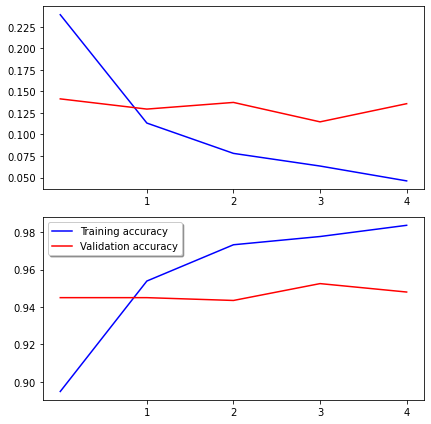

In [42]:
def plot_loss(history1):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.plot(history1.history['loss'], color='b', label="Training loss")
    ax1.plot(history1.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))

    ax2.plot(history1.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()
    
plot_loss(history1)

In [43]:
model_vgg.evaluate(test_ds, steps=test_len / 20)

25/25 [==============================] - 15s 591ms/step - loss: 7.2710 - accuracy: 0.4620


[7.271017551422119, 0.4620000123977661]

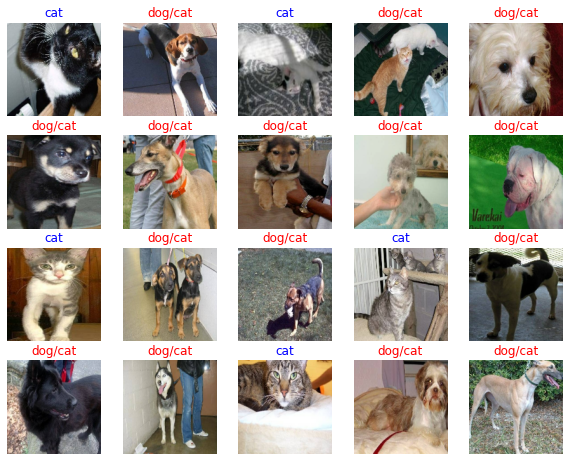

In [44]:
test_batch_size = 25

for images, labels in test_ds.take(1):
    predictions = model_vgg(images)

images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0: 'cat', 1: 'dog'}

# 시각화
fig = plt.figure(figsize=(10, 10))
for i, (px, py, y_pred) in enumerate(zip(images, labels, predictions)):
    p = fig.add_subplot(5, 5, i+1)
    if np.argmax(y_pred.numpy()) == py.numpy():
        p.set_title("{}".format(labels_map[py.numpy()]), color='blue')
    else:
        p.set_title("{}/{}".format(labels_map[np.argmax(y_pred.numpy())],
                                   labels_map[py.numpy()]), color='red')
    p.imshow(px.numpy()*0.5+0.5)
    p.axis('off')

In [45]:
# Define the data directory and image size
test_dir = "./datasets/test"
size = (150, 150)

batch_size = 20

# List filenames in the test directory
filenames = os.listdir(test_dir)
# print("Filenames:", filenames)


# Create a DataFrame for test data
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Adjust preprocessing as needed
test_idg = test_datagen.flow_from_dataframe(
    test_data,
    test_dir,
    x_col="filename",
    y_col='label',
    batch_size=batch_size,
    target_size=size,
    shuffle=False,
)

# Make predictions
test_predict = model.predict(test_idg, verbose=0)
test_predict_argmax = np.argmax(test_predict, axis=1)

# Map predictions to labels
label_mapping = {0: '0', 1: '1'}
# test_data['label'] = test_predict_argmax.map(label_mapping)
test_data['label'] = pd.Series(test_predict_argmax).map(label_mapping)


# Output to CSV
test_data.to_csv('test_predictions1.csv', index=False)

Found 500 validated image filenames belonging to 1 classes.
